In [99]:
%load_ext autoreload
%autoreload 2
import numpy as np # math
import matplotlib.pyplot as plt # graphs and plots
import pandas as pd
from tqdm import tqdm
import datetime
import matplotlib.dates as mdates
from src.utils.profiles_from_schedule_new import SimParam # class for show-up generator
from src.simfunc.KIX_T1d_CUSBD_new import Pax, Simulation , minutes_to_hms# classes for simulation
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
simparam = SimParam()
path_to_6k_sched = (
    r"/home/antoine/projects/"
    "KAPpaxsim/KAPpaxsim/data/"
    "processed/Schedule (30th terminal peak, 6000 pax)_PROCESSED.xlsx"
)
simparam.schedule_from_path(path_to_6k_sched)
simparam.schedule_cleanup()
simparam.schedule_filter()
simparam.show_up_from_file()
simparam.assign_flight_show_up_category_default()
# simparam.plot_show_up_categories_profiles()
simparam.schedule['PAX_SUM FC'] = 10
simparam.assign_show_up()
# simparam.plot_df_Pax()
simparam.assign_check_in()

In [ ]:
# simparam.df_Counters['total'].plot()

In [89]:
simparam.dct_resource = {
    'kiosk' : 92,
    'security' : 200,
    'CUSBD' : 192,
}

simparam.dct_processes = {
    'kiosk' : 70,
    'security': 1,
    'CUSBD': 60,
    'checkin': 70,
}

In [112]:
simulation = Simulation(simparam)
simulation.generate_checkin()
simulation.generate_pax()
simulation.run(end_time=5000)

Simulation running...:  16%|█▌        | 780/4999 [00:35<03:09, 22.25it/s] 


IndexError: list index out of range

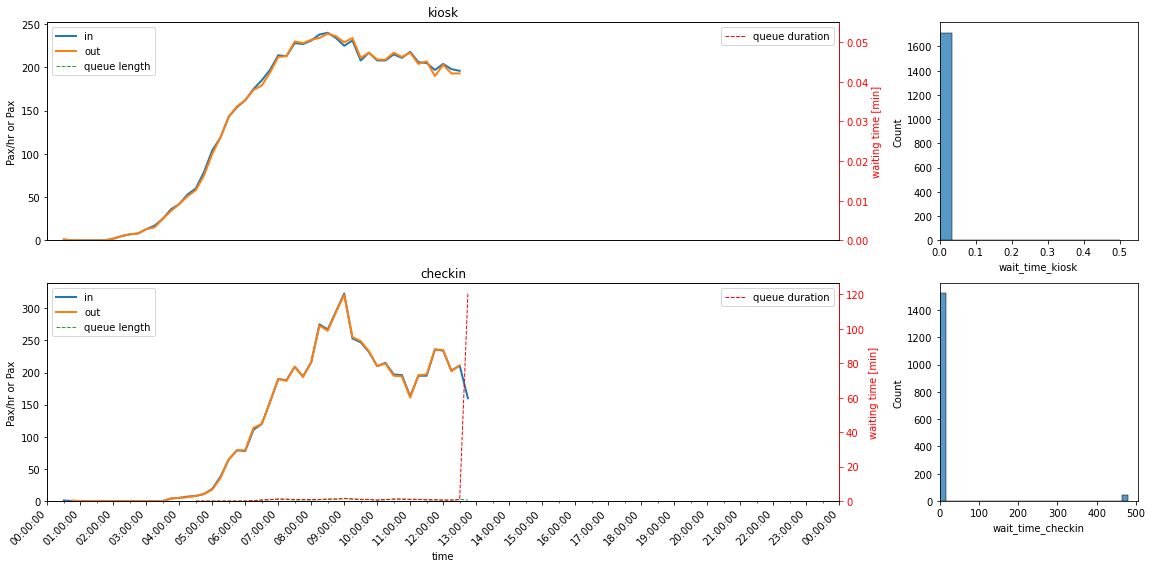

In [ ]:
simulation.format_df_result()
simulation.plot_result()

In [ ]:
df_result = pd.concat(
            [pax.row for pax in simulation.pax_list], axis=1
        ).transpose()

FREQ = "15min"
WINDOW = 4

In [ ]:
# sampling ratio
ratio_sampling = pd.to_timedelta("1H") / pd.to_timedelta(FREQ)

# list for iteration
list_process_all = ["kiosk", "checkin"]

# different types of columns
datetime_columns_types = [
    "start_{}_queue",
    "end_{}_queue",
    "end_{}_process",
]

datetime_columns = [
    a.format(b) for b in list_process_all for a in datetime_columns_types
]

# change datetime columns to datetime
for column in datetime_columns:
    df_result[column] = pd.to_datetime(
        df_result[column].apply(lambda x: minutes_to_hms(x))
    )

# calculate waiting times
for process in list_process_all:
    df_result["wait_time_{}".format(process)] = (
        df_result["end_{}_queue".format(process)]
        - df_result["start_{}_queue".format(process)]
    ).fillna(datetime.timedelta(0))

# artificial high waiting time for pax who did not finish
for process in list_process_all:
    mask = (pd.isna(df_result["end_{}_queue".format(process)])) & (
        pd.notna(df_result["start_{}_queue".format(process)])
    )

    df_result.loc[
        mask, "wait_time_{}".format(process)
    ] = datetime.timedelta(hours=8)

# aggregates for plotting
list_plot = [
    "start_{}_queue",
    "end_{}_process",
    "{}_queue_length",
    "wait_time_{}",
]
dct_plot = {
    key: [plot.format(key) for plot in list_plot] for key in list_process_all
}

# in
plt_in = [
    (
        df_result.set_index(dct_plot[key][0], drop=False)["Pax"]
        .resample(FREQ)
        .agg(["sum"])
        .rolling(window=WINDOW, center=True)
        .mean()
        .dropna()
        .apply(lambda x: x * ratio_sampling)
    )
    for key in [*dct_plot]
]

# out
plt_out = [
    (
        df_result.set_index(dct_plot[key][1], drop=False)["Pax"]
        .resample(FREQ)
        .agg(["sum"])
        .rolling(window=WINDOW, center=True)
        .mean()
        .dropna()
        .apply(lambda x: x * ratio_sampling)
    )
    for key in [*dct_plot]
]



In [ ]:
# queue length
plt_queue_length = [
    (
        df_result.set_index(dct_plot[key][0], drop=False)[
            dct_plot[key][2]
        ]
        .dropna()
        .resample(FREQ)
        .agg(["max"])
        .rolling(window=WINDOW, center=True)
        .mean()
    )
    for key in [*dct_plot]
]

# queue duration
plt_queue_duration = [
    (
        df_result.set_index(dct_plot[key][0], drop=False)[
            dct_plot[key][3]
        ]
        .apply(lambda x: x.total_seconds() / 60)
        .resample(FREQ)
        .agg(["max"])
        .rolling(window=WINDOW, center=True)
        .mean()
    )
    for key in [*dct_plot]
]

# histograms of queue duration and queue length
dct_hist_wait_time = {
    key: (
        df_result[df_result[dct_plot[key][0]].notnull()][
            dct_plot[key][3]
        ].apply(lambda x: x.total_seconds() / 60)
    )
    for key in [*dct_plot]
}

dct_hist_queue_length = {
    key: (
        df_result[df_result[dct_plot[key][0]].notnull()][
            dct_plot[key][2]
        ]
    )
    for key in [*dct_plot]
}

plt_hist_wait_time = [value for value in dct_hist_wait_time.values()]


In [ ]:
dct_plot

{'kiosk': ['start_kiosk_queue',
  'end_kiosk_process',
  'kiosk_queue_length',
  'wait_time_kiosk'],
 'checkin': ['start_checkin_queue',
  'end_checkin_process',
  'checkin_queue_length',
  'wait_time_checkin']}

In [ ]:
df_result.set_index(dct_plot['checkin'][0], drop=False)[dct_plot['checkin'][2]]

start_checkin_queue
NaT                    NaN
NaT                    NaN
NaT                    NaN
NaT                    NaN
NaT                    NaN
                      ... 
2020-10-13 09:00:00      0
2020-10-13 09:00:00      0
2020-10-13 09:16:53      0
2020-10-13 09:46:26      0
2020-10-13 11:04:23      0
Name: checkin_queue_length, Length: 3010, dtype: object

In [ ]:
df_result

,Flight Number,time,Scheduled Time,Category,Pax,minutes,kiosk_queue_length,start_kiosk_queue,end_kiosk_queue,end_kiosk_process,checkin_queue_length,start_checkin_queue,end_checkin_queue,end_checkin_process
0,TAX 611,2020-10-13 18:26:45,2020-10-13 00:10:00,FSC,1,1106.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TAX 611,2020-10-13 19:44:43,2020-10-13 00:10:00,FSC,1,1184.716667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TAX 611,2020-10-13 20:14:14,2020-10-13 00:10:00,FSC,1,1214.233333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TAX 611,2020-10-13 20:36:19,2020-10-13 00:10:00,FSC,1,1236.316667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TAX 611,2020-10-13 20:55:41,2020-10-13 00:10:00,FSC,1,1255.683333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,NEW 134,2020-10-13 08:34:18,2020-10-13 11:30:00,FSC,1,514.3,0,514.3,514.3,515.466667,0,540.0,540.0,541.166667
3006,NEW 134,2020-10-13 08:53:40,2020-10-13 11:30:00,FSC,1,533.666667,0,533.666667,533.666667,534.833333,0,540.0,540.0,541.166667
3007,NEW 134,2020-10-13 09:15:44,2020-10-13 11:30:00,FSC,1,555.733333,0,555.733333,555.733333,556.9,0,556.9,556.9,558.066667
3008,NEW 134,2020-10-13 09:45:17,2020-10-13 11:30:00,FSC,1,585.283333,0,585.283333,585.283333,586.45,0,586.45,586.45,587.616667


In [ ]:
simulation.pax_list[1500].row

Flight Number                       HAL 450 
time                     2020-10-13 15:21:45
Scheduled Time           2020-10-13 21:05:00
Category                                 FSC
Pax                                        1
minutes                               921.75
kiosk_queue_length                         0
start_kiosk_queue                     921.75
end_kiosk_queue                       921.75
end_kiosk_process                 922.916667
security_queue_length                      0
start_security_queue              922.916667
end_security_queue                922.916667
end_security_process              922.933333
CUSBD_queue_length                         0
start_CUSBD_queue                     1115.0
end_CUSBD_queue                       1115.0
end_CUSBD_process                     1116.0
Name: 1500, dtype: object

In [ ]:
simulation.df_result['time'][0].hour

18

In [ ]:
simulation.df_result[simulation.df_result['time'].apply(lambda x : x.hour) == 16]

,Flight Number,time,Scheduled Time,Category,Pax,minutes,kiosk_queue_length,start_kiosk_queue,end_kiosk_queue,end_kiosk_process,security_queue_length,start_security_queue,end_security_queue,end_security_process,CUSBD_queue_length,start_CUSBD_queue,end_CUSBD_queue,end_CUSBD_process,wait_time_kiosk,wait_time_security
1009,JJA 1383,2020-10-13 16:03:14,2020-10-13 16:30:00,FSC,1,963.233333,0,2020-10-13 16:03:14,2020-10-13 16:03:14,2020-10-13 16:04:23,0,2020-10-13 16:04:23,2020-10-13 16:04:23,2020-10-13 16:04:24,0,964.416667,964.416667,965.416667,0 days,0 days
1039,XAX 537,2020-10-13 16:13:14,2020-10-13 16:40:00,FSC,1,973.233333,0,2020-10-13 16:13:14,2020-10-13 16:13:14,2020-10-13 16:14:23,0,2020-10-13 16:14:23,2020-10-13 16:14:23,2020-10-13 16:14:24,0,974.416667,974.416667,975.416667,0 days,0 days
1049,DKH 1340,2020-10-13 16:13:14,2020-10-13 16:40:00,FSC,1,973.233333,0,2020-10-13 16:13:14,2020-10-13 16:13:14,2020-10-13 16:14:23,0,2020-10-13 16:14:23,2020-10-13 16:14:23,2020-10-13 16:14:24,0,974.416667,974.416667,975.416667,0 days,0 days
1059,PAL 897,2020-10-13 16:23:14,2020-10-13 16:50:00,FSC,1,983.233333,0,2020-10-13 16:23:14,2020-10-13 16:23:14,2020-10-13 16:24:23,0,2020-10-13 16:24:23,2020-10-13 16:24:23,2020-10-13 16:24:24,0,984.416667,984.416667,985.416667,0 days,0 days
1069,CES 748,2020-10-13 16:28:14,2020-10-13 16:55:00,FSC,1,988.233333,0,2020-10-13 16:28:14,2020-10-13 16:28:14,2020-10-13 16:29:23,0,2020-10-13 16:29:23,2020-10-13 16:29:23,2020-10-13 16:29:24,0,989.416667,989.416667,990.416667,0 days,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2979,NEW 129,2020-10-13 16:13:14,2020-10-13 16:40:00,FSC,1,973.233333,0,2020-10-13 16:13:14,2020-10-13 16:13:14,2020-10-13 16:14:23,0,2020-10-13 16:14:23,2020-10-13 16:14:23,2020-10-13 16:14:24,0,974.416667,974.416667,975.416667,0 days,0 days
2984,NEW 130,2020-10-13 16:15:41,2020-10-13 19:30:00,FSC,1,975.683333,0,2020-10-13 16:15:40,2020-10-13 16:15:40,2020-10-13 16:16:50,0,2020-10-13 16:16:50,2020-10-13 16:16:50,2020-10-13 16:16:51,0,1020.0,1020.0,1021.0,0 days,0 days
2985,NEW 130,2020-10-13 16:34:18,2020-10-13 19:30:00,FSC,1,994.3,0,2020-10-13 16:34:17,2020-10-13 16:34:17,2020-10-13 16:35:27,0,2020-10-13 16:35:27,2020-10-13 16:35:27,2020-10-13 16:35:28,0,1020.0,1020.0,1021.0,0 days,0 days
2986,NEW 130,2020-10-13 16:53:40,2020-10-13 19:30:00,FSC,1,1013.666667,0,2020-10-13 16:53:39,2020-10-13 16:53:39,2020-10-13 16:54:49,0,2020-10-13 16:54:49,2020-10-13 16:54:49,2020-10-13 16:54:50,0,1020.0,1020.0,1021.0,0 days,0 days


In [ ]:
len(simulation.checkin['DKH'].queue)

AttributeError: 'Simulation' object has no attribute 'checkin'